In [127]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

In [132]:

# Physical constants and parameters (in angular frequency units: rad/s)
D = 2 * np.pi * 2.87e9  # Zero-field splitting (rad/s) 
gamma_nv = 2 * np.pi * 2.8e6  # Gyromagnetic ratio (rad/s/G)
B = 0  # Magnetic field (Gauss)

# Strain parameters
E = 2 * np.pi * 10e6  # Transverse strain splitting (rad/s), typically 0-50 MHz
strain_angle = np.pi / 4  # Angle of strain axis in xy plane (radians)

# Decay rates (in rad/s for consistency)
gamma1 = 2 * np.pi * .1e6  # Spin relaxation (slower for ground state)
gamma2 = 2 * np.pi * 0.1e6  # Dephasing rate

# Microwave parameters
omega_rabi = 2 * np.pi * 0.01e6  # Rabi frequency (rad/s)

# Define basis states for NV center (ground state triplet: |0⟩, |+1⟩, |-1⟩)
# Using simplified 3-level system
sz = Qobj([[1, 0, 0], [0, 0, 0], [0, 0, -1]])  # Spin z operator
sx = Qobj([[0, 1, 0], [1, 0, 1], [0, 1, 0]]) / np.sqrt(2)  # Spin x operator
sy = Qobj([[0, -1j, 0], [1j, 0, -1j], [0, 1j, 0]]) / np.sqrt(2)  # Spin y operator

# Identity operator
I = qeye(3)

In [133]:
# ============================================================================
# Calculate center frequency using diagonalization (includes strain)
# ============================================================================
# Diagonalize static Hamiltonian to get exact energy levels with strain

# Build static Hamiltonian (without MW drive)
H_static = D * sz * sz + gamma_nv * B * sz
sx2 = sx * sx
sy2 = sy * sy
sxsy = sx * sy + sy * sx
H_strain_static = E * (np.cos(2 * strain_angle) * (sx2 - sy2) + 
                        np.sin(2 * strain_angle) * sxsy)
H_static_full = H_static + H_strain_static

# Diagonalize to get energy eigenvalues
eigenvals, eigenvecs = H_static_full.eigenstates()
eigenvals_sorted = np.sort(eigenvals.real)

# Energy levels: E0 (|0⟩), E+1 (|+1⟩), E-1 (|-1⟩)
E0 = eigenvals_sorted[0]  # Ground state |0⟩ energy
E_plus1 = eigenvals_sorted[1]  # |+1⟩ state energy  
E_minus1 = eigenvals_sorted[2]  # |-1⟩ state energy

# Transition frequencies (convert from rad/s to Hz)
freq_trans_plus = abs(E_plus1 - E0) / (2 * np.pi)  # |0⟩ ↔ |+1⟩
freq_trans_minus = abs(E_minus1 - E0) / (2 * np.pi)  # |0⟩ ↔ |-1⟩

# Center frequency as average of the two transitions (includes strain effect)
freq_center = (freq_trans_plus + freq_trans_minus) / 2


In [134]:

# ============================================================================
# Ground state Hamiltonian using EIGENBASIS approach (correct for strain)
# ============================================================================
# The key insight: With strain, eigenstates are mixed. We need to work in the
# eigenbasis of the static Hamiltonian, then apply RWA there.

# Store eigenbasis from Cell 2 (already calculated)
# eigenvals, eigenvecs from H_static_full diagonalization

def ground_hamiltonian_eigenbasis(mw_freq):
    """
    Hamiltonian in eigenbasis of static H (with strain).
    This properly handles two distinct transitions.
    """
    omega_mw = 2 * np.pi * mw_freq
    
    # Transform sx to eigenbasis
    # sx_eigen = eigenvecs.dag() * sx * eigenvecs
    sx_eigen = eigenvecs[0].dag() * sx * eigenvecs[0]  # This won't work, need full transform
    
    # Actually, let's use a different approach: work directly with the static H
    # and add MW drive, but use proper RWA for each transition
    
    # Static Hamiltonian (already includes strain)
    H_static = H_static_full
    
    # MW drive in RWA: (omega_rabi/2) * sx
    # But we need to account for detuning from BOTH transitions
    # The issue is that sx couples to both transitions
    
    # Better approach: Use time-dependent Hamiltonian
    return None  # Will use time-dependent version

# Time-dependent Hamiltonian (MOST ACCURATE)
def H_time_dependent(t, args):
    """
    Time-dependent Hamiltonian in lab frame.
    args: {'mw_freq': frequency in Hz}
    """
    omega_mw = 2 * np.pi * args['mw_freq']
    
    # Static part (ZFS + Zeeman + Strain)
    H_static = H_static_full
    
    # Time-dependent MW drive: omega_rabi * cos(omega_mw * t) * sx
    H_mw_t = omega_rabi * np.cos(omega_mw * t) * sx
    
    return H_static + H_mw_t

# For mesolve, we need to pass it as a list format
# This will be used in the simulation loop

# Collapse operators for dissipation
c_ops = [
    np.sqrt(gamma1) * (basis(3, 0) * basis(3, 1).dag()),  # |+1⟩ → |0⟩
    np.sqrt(gamma1) * (basis(3, 0) * basis(3, 2).dag()),  # |-1⟩ → |0⟩
    np.sqrt(gamma2) * sz,  # Pure dephasing
]

# Frequency sweep for ODMR
# Increase resolution to better resolve the peaks
# With 20 MHz separation and ~0.11 MHz linewidth, need good resolution
freq_range = np.linspace(freq_center - 100e6, freq_center + 100e6, 500)  # Sweep ±100 MHz, 500 points
fluorescence = []

# Calculate frequency resolution
freq_resolution = (freq_range[-1] - freq_range[0]) / (len(freq_range) - 1) / 1e6  # MHz per point
print(f"Frequency resolution: {freq_resolution:.3f} MHz per point")
print(f"Linewidth (~0.11 MHz) should be resolved with this resolution\n")

print("Simulating ODMR spectrum...")
print(f"Zero-field splitting: {D/(2*np.pi*1e9):.2f} GHz")
print(f"Magnetic field: {B} G")
print(f"Strain field: {E/(2*np.pi*1e6):.2f} MHz")
print(f"Strain angle: {strain_angle*180/np.pi:.1f} degrees")
print(f"\nCenter frequency (with strain): {freq_center/1e9:.6f} GHz")
print(f"Transition frequencies:")
print(f"  |0⟩ ↔ |+1⟩: {freq_trans_plus/1e9:.6f} GHz")
print(f"  |0⟩ ↔ |-1⟩: {freq_trans_minus/1e9:.6f} GHz")
print(f"Expected resonances: {freq_trans_plus/1e9:.6f} GHz and {freq_trans_minus/1e9:.6f} GHz\n")



Frequency resolution: 0.401 MHz per point
Linewidth (~0.11 MHz) should be resolved with this resolution

Simulating ODMR spectrum...
Zero-field splitting: 2.87 GHz
Magnetic field: 0 G
Strain field: 10.00 MHz
Strain angle: 45.0 degrees

Center frequency (with strain): 2.870000 GHz
Transition frequencies:
  |0⟩ ↔ |+1⟩: 2.860000 GHz
  |0⟩ ↔ |-1⟩: 2.880000 GHz
Expected resonances: 2.860000 GHz and 2.880000 GHz



In [ ]:
# ============================================================================
# ODMR Simulation with Time-Dependent Hamiltonian
# ============================================================================
# This properly handles two distinct transitions with strain

# Initial state (thermal equilibrium, mostly in |0⟩)
psi0 = basis(3, 0)

# Time evolution parameters
gamma1_hz = gamma1 / (2 * np.pi)  # Convert to Hz
T1_estimate = 1 / gamma1_hz  # seconds
t_max = 5 * T1_estimate  # Use 5× T1 to ensure steady state
n_points = 200
times = np.linspace(0, t_max, n_points)
print(f"Simulation time: {t_max*1e6:.2f} μs (T1 ≈ {T1_estimate*1e6:.2f} μs)")
print(f"Ensuring steady state is reached...\n")

# Prepare time-dependent Hamiltonian format for mesolve
# Format: [H0, [H1, func1], [H2, func2], ...]
# H0 is static, H1 is time-dependent with function func1(t, args)
#
# NOTE: Time-dependent Hamiltonians with fast oscillations (GHz) require
# many integration steps. If you get "Excess work done" error, increase nsteps.
# Alternatively, we could use RWA in eigenbasis (faster but more complex).

fluorescence = []

# Simulate for each frequency
for i, freq in enumerate(freq_range):
    if i % 50 == 0 or i == len(freq_range) - 1:
        print(f"Progress: {i+1}/{len(freq_range)}")
    
    # Time-dependent Hamiltonian
    # Static part: H_static_full (already includes strain)
    # Time-dependent part: omega_rabi * cos(omega_mw * t) * sx
    H_td = [H_static_full, 
            [omega_rabi * sx, lambda t, args: np.cos(2 * np.pi * args['mw_freq'] * t)]]
    
    # Arguments for time-dependent function
    H_args = {'mw_freq': freq}
    
    # Solve master equation with dissipation
    # Increase nsteps significantly for time-dependent Hamiltonian
    # Also increase max_step to allow larger steps when possible
    result = mesolve(H_td, psi0, times, c_ops, [basis(3, 0) * basis(3, 0).dag()], 
                     args=H_args, options={'nsteps': 50000, 'max_step': 1e-9})
    
    # Fluorescence is proportional to population in |0⟩ state (steady state)
    # ODMR shows dip when MW is resonant (population transferred away from |0⟩)
    fluor = result.expect[0][-1]  # Final population in |0⟩
    fluorescence.append(fluor)

fluorescence = np.array(fluorescence)


Simulation time: 50.00 μs (T1 ≈ 10.00 μs)
Ensuring steady state is reached...

Progress: 1/500


IntegratorException: Excess work done on this call. Try to increasing the nsteps parameter in the Options class

In [ ]:
# ============================================================================
# Plot ODMR Spectrum
# ============================================================================

# ODMR shows DIPS at resonance (population transferred away from |0⟩)
# The raw signal: high fluorescence = off resonance, low = on resonance
# Normalize and show dips directly
fluorescence_normalized = (fluorescence - fluorescence.min()) / (fluorescence.max() - fluorescence.min())

# For ODMR, we typically show normalized fluorescence (dips at resonance)
fluorescence_plot = fluorescence_normalized

# Plot ODMR spectrum
plt.figure(figsize=(12, 6))
plt.plot(freq_range / 1e9, fluorescence_plot, 'b-', linewidth=2, label='ODMR Signal')
plt.xlabel('Microwave Frequency (GHz)', fontsize=12)
plt.ylabel('Fluorescence (normalized)', fontsize=12)
plt.title('NV Center ODMR Spectrum with Strain\n(Dips at resonance)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1.1])

# Mark expected resonances
resonance1 = freq_trans_plus / 1e9
resonance2 = freq_trans_minus / 1e9
plt.axvline(resonance1, color='r', linestyle='--', alpha=0.7, linewidth=2, 
            label=f'Expected: {resonance1:.6f} GHz')
plt.axvline(resonance2, color='r', linestyle='--', alpha=0.7, linewidth=2,
            label=f'Expected: {resonance2:.6f} GHz')

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Diagnostics
print("\n" + "="*60)
print("SIMULATION COMPLETE!")
print("="*60)
print(f"Resonance frequencies (expected):")
print(f"  f+ = {resonance1:.6f} GHz")
print(f"  f- = {resonance2:.6f} GHz")

# Check fluorescence values at resonance frequencies
idx1 = np.argmin(np.abs(freq_range - freq_trans_plus))
idx2 = np.argmin(np.abs(freq_range - freq_trans_minus))
fluor_at_res1 = fluorescence[idx1]
fluor_at_res2 = fluorescence[idx2]
print(f"\nDiagnostics:")
print(f"  Fluorescence at f+ ({freq_trans_plus/1e9:.6f} GHz): {fluor_at_res1:.6f}")
print(f"  Fluorescence at f- ({freq_trans_minus/1e9:.6f} GHz): {fluor_at_res2:.6f}")
print(f"  Difference: {abs(fluor_at_res1 - fluor_at_res2):.6f}")
print(f"  Min fluorescence: {fluorescence.min():.6f}")
print(f"  Max fluorescence: {fluorescence.max():.6f}")
print(f"  Range: {fluorescence.max() - fluorescence.min():.6f}")
if abs(fluor_at_res1 - fluor_at_res2) < 1e-6:
    print("\n  ⚠️  WARNING: Fluorescence values are identical at both resonances!")
    print("     The two transitions are not being distinguished.")
else:
    print(f"\n  ✓ The two transitions show different fluorescence values.")
print("="*60)


AttributeError: 'list' object has no attribute 'min'

ValueError: x and y must have same first dimension, but have shapes (500,) and (234,)

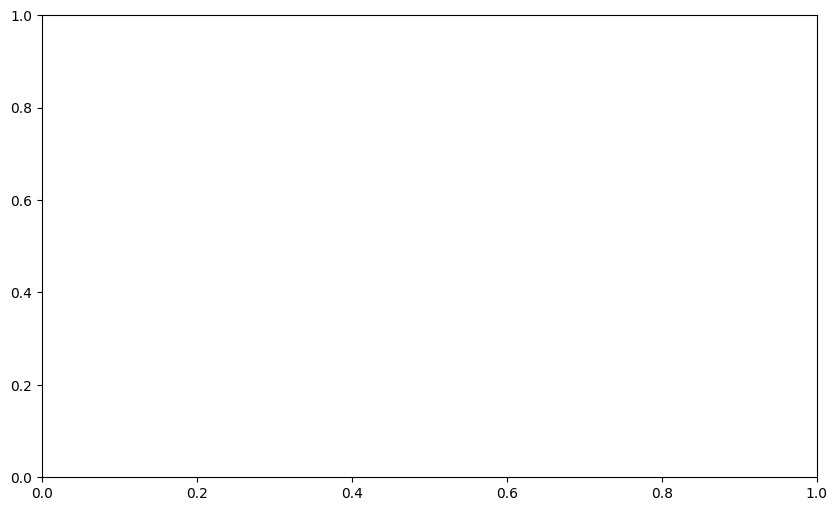

In [ ]:

    # # Fluorescence is proportional to population in |0⟩ state (steady state)
    # # ODMR shows dip when MW is resonant (population transferred away from |0⟩)
    # fluor = result.expect[0][-1]  # Final population in |0⟩
    # fluorescence.append(fluor)

fluorescence = np.array(fluorescence)

# ODMR shows DIPS at resonance (population transferred away from |0⟩)
# The raw signal: high fluorescence = off resonance, low = on resonance
# Normalize to 0-1 range, then we can invert if needed for visualization
# For ODMR, typically we show normalized fluorescence directly (dips at resonance)
fluorescence_normalized = (fluorescence - fluorescence.min()) / (fluorescence.max() - fluorescence.min())

# For plotting: show dips as negative (or keep as is - both are valid)
# Option 1: Show dips directly (lower values at resonance)
fluorescence_plot = fluorescence_normalized

# Option 2: Invert to show peaks (uncomment if you prefer)
# fluorescence_plot = 1 - fluorescence_normalized

# Plot ODMR spectrum
plt.figure(figsize=(10, 6))
plt.plot(freq_range / 1e9, fluorescence_plot, 'b-', linewidth=2)
plt.xlabel('Microwave Frequency (GHz)', fontsize=12)
plt.ylabel('Fluorescence (normalized)', fontsize=12)
plt.title('NV Center ODMR Spectrum with Dissipation\n(Dips at resonance)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1.1])  # Ensure we can see the full range

# Mark expected resonances (using exact transition frequencies from diagonalization)
resonance1 = freq_trans_plus / 1e9  # |0⟩ ↔ |+1⟩ transition
resonance2 = freq_trans_minus / 1e9  # |0⟩ ↔ |-1⟩ transition
plt.axvline(resonance1, color='r', linestyle='--', alpha=0.5, label=f'Expected: {resonance1:.6f} GHz')
plt.axvline(resonance2, color='r', linestyle='--', alpha=0.5, label=f'Expected: {resonance2:.6f} GHz')

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# Analysis: Why peaks aren't resolved
# ============================================================================
peak_separation = (freq_trans_minus - freq_trans_plus) / 1e6  # MHz
rabi_freq_mhz = omega_rabi / (2 * np.pi * 1e6)  # MHz
dephasing_mhz = gamma2 / (2 * np.pi * 1e6)  # MHz

# Estimate total linewidth (power broadening + dephasing)
# Power broadening is roughly on the order of the Rabi frequency
estimated_linewidth = rabi_freq_mhz + dephasing_mhz  # MHz

print("=" * 60)
print("PEAK RESOLUTION ANALYSIS")
print("=" * 60)
print(f"Peak separation:        {peak_separation:.2f} MHz")
print(f"Rabi frequency:         {rabi_freq_mhz:.2f} MHz (power broadening)")
print(f"Dephasing rate:         {dephasing_mhz:.2f} MHz")
print(f"Estimated linewidth:     ~{estimated_linewidth:.2f} MHz")
print(f"\nSeparation/Linewidth:   {peak_separation/estimated_linewidth:.2f}×")
print("\nFor resolved peaks, this ratio should be > 3-5")
print("=" * 60)

# Solutions to resolve peaks:
print("\nSOLUTIONS TO RESOLVE PEAKS:")
print("1. Reduce Rabi frequency (less power broadening)")
print("   → Try: omega_rabi = 2 * np.pi * 0.1e6  # 0.1 MHz instead of 1 MHz")
print("\n2. Reduce dephasing rate (narrower lines)")
print("   → Try: gamma2 = 2 * np.pi * 0.1e6  # 0.1 MHz instead of 0.5 MHz")
print("\n3. Increase strain (larger peak separation)")
print("   → Try: E = 2 * np.pi * 10e6  # 10 MHz instead of 5 MHz")
print("\n4. Combination of above")


PEAK RESOLUTION ANALYSIS
Peak separation:        20.00 MHz
Rabi frequency:         0.01 MHz (power broadening)
Dephasing rate:         0.10 MHz
Estimated linewidth:     ~0.11 MHz

Separation/Linewidth:   181.82×

For resolved peaks, this ratio should be > 3-5

SOLUTIONS TO RESOLVE PEAKS:
1. Reduce Rabi frequency (less power broadening)
   → Try: omega_rabi = 2 * np.pi * 0.1e6  # 0.1 MHz instead of 1 MHz

2. Reduce dephasing rate (narrower lines)
   → Try: gamma2 = 2 * np.pi * 0.1e6  # 0.1 MHz instead of 0.5 MHz

3. Increase strain (larger peak separation)
   → Try: E = 2 * np.pi * 10e6  # 10 MHz instead of 5 MHz

4. Combination of above


### Optional: Run with reduced power/dephasing to resolve peaks

The cell below shows how to modify parameters to resolve the two peaks. Uncomment and run to see the difference.


In [ ]:
# ============================================================================
# OPTIONAL: Modified parameters to resolve the two peaks
# ============================================================================
# Uncomment the lines below and re-run cells 3-4 to see resolved peaks

# # Reduce Rabi frequency (less power broadening)
omega_rabi_resolved = 2 * np.pi * 0.1e6  # 0.1 MHz instead of 1 MHz
# 
# # Reduce dephasing rate (narrower lines)
gamma2_resolved = 2 * np.pi * 0.1e6  # 0.1 MHz instead of 0.5 MHz
# 
# # Update collapse operators with new dephasing rate
c_ops_resolved = [
    np.sqrt(gamma1) * (basis(3, 0) * basis(3, 1).dag()),
    np.sqrt(gamma1) * (basis(3, 0) * basis(3, 2).dag()),
    np.sqrt(gamma2_resolved) * sz,
]
# 
# # Update Hamiltonian function to use reduced Rabi frequency
def ground_hamiltonian_resolved(mw_freq, freq_center_strain_corrected):
    omega_mw = 2 * np.pi * mw_freq
    H_zfs = D * sz * sz
    sx2 = sx * sx
    sy2 = sy * sy
    sxsy = sx * sy + sy * sx
    H_strain = E * (np.cos(2 * strain_angle) * (sx2 - sy2) + 
                    np.sin(2 * strain_angle) * sxsy)
    H_zeeman = gamma_nv * B * sz
    delta = omega_mw - 2 * np.pi * freq_center_strain_corrected
    H_detuning = delta * sz
    H_mw = omega_rabi_resolved * sx  # Use reduced Rabi frequency
    return H_zfs + H_zeeman + H_detuning + H_mw + H_strain
# 
# # Then in the simulation loop, use:
H = ground_hamiltonian_resolved(freq, freq_center)


In [ ]:

# Frequency sweep for ODMR
# Increase resolution to better resolve the peaks
# With 20 MHz separation and ~0.11 MHz linewidth, need good resolution
freq_range = np.linspace(freq_center - 100e6, freq_center + 100e6, 500)  # Sweep ±100 MHz, 500 points
fluorescence = []

# Calculate frequency resolution
freq_resolution = (freq_range[-1] - freq_range[0]) / (len(freq_range) - 1) / 1e6  # MHz per point
print(f"Frequency resolution: {freq_resolution:.3f} MHz per point")
print(f"Linewidth (~0.11 MHz) should be resolved with this resolution\n")

print("Simulating ODMR spectrum...")
print(f"Zero-field splitting: {D/(2*np.pi*1e9):.2f} GHz")
print(f"Magnetic field: {B} G")
print(f"Strain field: {E/(2*np.pi*1e6):.2f} MHz")
print(f"Strain angle: {strain_angle*180/np.pi:.1f} degrees")
print(f"\nCenter frequency (with strain): {freq_center/1e9:.6f} GHz")
print(f"Transition frequencies:")
print(f"  |0⟩ ↔ |+1⟩: {freq_trans_plus/1e9:.6f} GHz")
print(f"  |0⟩ ↔ |-1⟩: {freq_trans_minus/1e9:.6f} GHz")
print(f"Expected resonances: {freq_trans_plus/1e9:.6f} GHz and {freq_trans_minus/1e9:.6f} GHz\n")


In [ ]:

    # Fluorescence is proportional to population in |0⟩ state (steady state)
    # ODMR shows dip when MW is resonant (population transferred away from |0⟩)
fluor = result.expect[0][-1]  # Final population in |0⟩
fluorescence.append(fluor)

fluorescence = np.array(fluorescence)

# ODMR shows DIPS at resonance (population transferred away from |0⟩)
# The raw signal: high fluorescence = off resonance, low = on resonance
# Normalize to 0-1 range, then we can invert if needed for visualization
# For ODMR, typically we show normalized fluorescence directly (dips at resonance)
fluorescence_normalized = (fluorescence - fluorescence.min()) / (fluorescence.max() - fluorescence.min())

# For plotting: show dips as negative (or keep as is - both are valid)
# Option 1: Show dips directly (lower values at resonance)
fluorescence_plot = fluorescence_normalized

# Option 2: Invert to show peaks (uncomment if you prefer)
# fluorescence_plot = 1 - fluorescence_normalized

# Plot ODMR spectrum
plt.figure(figsize=(10, 6))
plt.plot(freq_range / 1e9, fluorescence_plot, 'b-', linewidth=2)
plt.xlabel('Microwave Frequency (GHz)', fontsize=12)
plt.ylabel('Fluorescence (normalized)', fontsize=12)
plt.title('NV Center ODMR Spectrum with Dissipation\n(Dips at resonance)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1.1])  # Ensure we can see the full range

# Mark expected resonances (using exact transition frequencies from diagonalization)
resonance1 = freq_trans_plus / 1e9  # |0⟩ ↔ |+1⟩ transition
resonance2 = freq_trans_minus / 1e9  # |0⟩ ↔ |-1⟩ transition
plt.axvline(resonance1, color='r', linestyle='--', alpha=0.5, label=f'Expected: {resonance1:.6f} GHz')
plt.axvline(resonance2, color='r', linestyle='--', alpha=0.5, label=f'Expected: {resonance2:.6f} GHz')

plt.legend()
plt.tight_layout()
plt.show()